## 1. Import statements

In [170]:
import numpy as np
from itertools import permutations
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
from egttools.analytical import PairwiseComparison
from egttools.games import AbstractTwoPLayerGame
from egttools.games import NormalFormGame
import egttools as egt


## 2. Global variables

In [171]:
R = 1
S = -1
T = 2
P = 0

NUM_ROUNDS = 50 # number of rounds
N = 100 # population size
BETA = 0.1

THETA = 3 # trust threshold
CHECK_PROBABILITY = 0.25 # p

EPSILON = 0.25 # opportunity cost


STRATEGIES = ['AllC', 'AllD', 'TFT', 'TUC', 'TUD'] # Strategy names

STRATEGY_COLORS = { # for plotting
    'AllC': '#7cfc00',
    'AllD': 'r',
    'TFT':  'b',
    'TUC':  '#a020f0',
    'TUD':  '#eeb422'
}

## 3. Payoff matrix
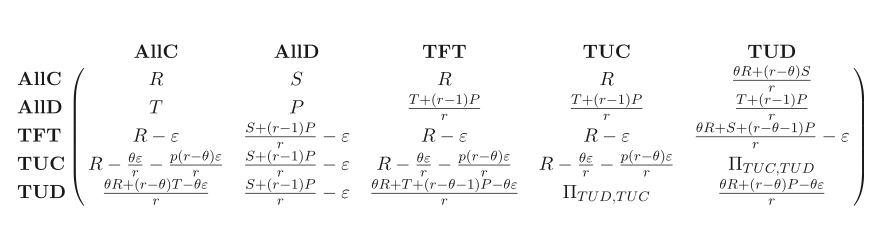
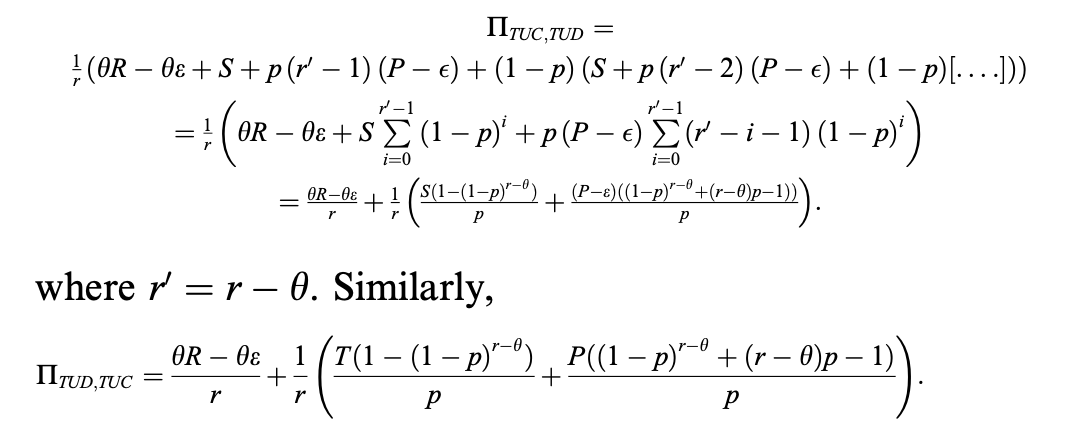

In [172]:
def initialize_payoff_matrix(
    # 1) payoff matrix weights
    R: int, # reward
    S: int, # sucker
    T: int, # temptation
    P: int, # punishment
    # 2) trust metrics
    theta: int,
    check_co_player_probability: int,
    # 3) game variables
    epsilon: int, # opportunity cost
    r: int, # number of (repeated) rounds
    with_trust_based_strategies: bool = True # whether to add TUC / TUD (to differentiate whether cooperation improves in experiments)
    ):

    # helper function to divide by the number of rounds
    def norm_rounds(expr):
        return expr / r
    # helper function to normalize AND subtract opportunity cost
    def norm_and_opp_cost(expr):
        return norm_rounds(expr) - epsilon
    
    def tuc_vs_tud():
        return norm_rounds(theta*R - theta*epsilon) + 1/r * ( (S*(1-(1-check_co_player_probability)**(r-theta)))/check_co_player_probability + ((P-epsilon)*((1-check_co_player_probability)**(r-theta)+(r-theta)*check_co_player_probability-1))/check_co_player_probability)
    
    def tud_vs_tuc():
        return norm_rounds(theta*R - theta*epsilon) + 1/r * ( (T*(1-(1-check_co_player_probability)**(r-theta)))/check_co_player_probability + (P*((1-check_co_player_probability)**(r-theta)+ (r-theta)*check_co_player_probability - 1))/check_co_player_probability)
    
    complete_payoff = [
        # A11C
        [R, S, R, R, norm_rounds(theta*R + (r - theta)*S)],
        # A11D
        [T, P, norm_rounds(T + (r-1)*P), norm_rounds(T + (r-1)*P), norm_rounds(T + (r-1)*P)],
        # TFT
        [R-epsilon, norm_and_opp_cost(S+(r-1)*P), R-epsilon, R-epsilon, norm_and_opp_cost(theta*R+S+(r-theta-1)*P)],
        # TUC
        [R - norm_rounds(theta*epsilon) - norm_rounds(check_co_player_probability*(r-theta)*epsilon), norm_and_opp_cost(S+(r-1)*P), R - norm_rounds(theta*epsilon) - norm_rounds(check_co_player_probability*(r-theta)*epsilon), R-norm_rounds(theta*epsilon)-norm_rounds(check_co_player_probability*(r-theta)*epsilon), tuc_vs_tud()],
        # TUD
        [norm_rounds(theta*R + (r-theta)*T - theta*epsilon), norm_and_opp_cost(S+(r-1)*P), norm_rounds(theta*R+T+(r-theta-1)*P-theta*epsilon), tud_vs_tuc(), norm_rounds(theta*R+(r-theta)*P-theta*epsilon)]
    ]
    
    return complete_payoff if with_trust_based_strategies else [row[:3] for row in complete_payoff[:3]]
    
    


In [173]:
def get_stationary_distribution(payoff_matrix):
    # 0) defines a 2-player game, in this case I took Matrix2PlayerGameHolder to initialize game based on pay-off matrix
    # source: https://egttools.readthedocs.io/en/latest/_autosummary/egttools.games.Matrix2PlayerGameHolder.html#egttools.games.Matrix2PlayerGameHolder
    game = egt.games.Matrix2PlayerGameHolder(len(payoff_matrix), payoff_matrix)

    # 1) define the evolver
    evolver = egt.analytical.PairwiseComparison(N, game)

    # 2) calculate distribution(s)
    transition_matrix, fixation_probabilities = evolver.calculate_transition_and_fixation_matrix_sml(BETA)
    stationary = egt.utils.calculate_stationary_distribution(transition_matrix.T)

    # 3) null checks & transform near null
    stationary = np.real_if_close(np.asarray(stationary, dtype=float))
    stationary = stationary / stationary.sum()

    return stationary


## Figure 3a

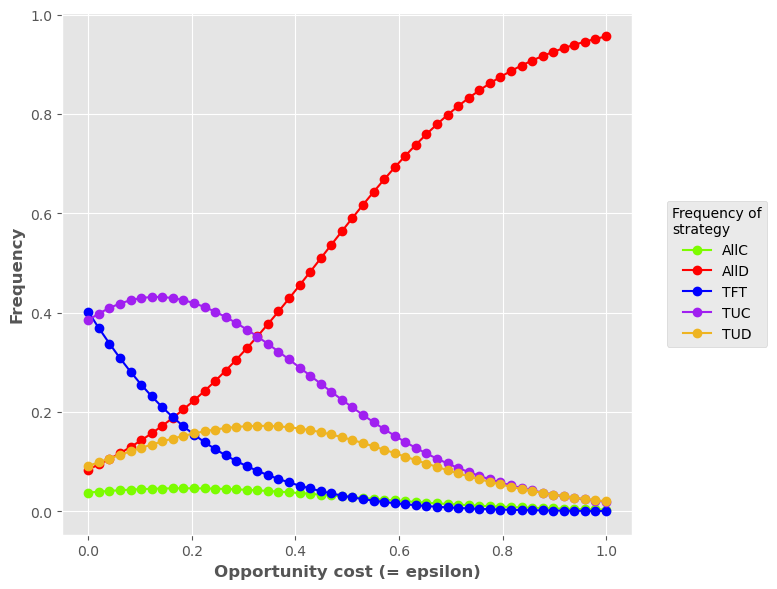

In [174]:
epsilon_values = np.linspace(0, 1, 50)
strategy_frequency_data = {strat: [] for strat in STRATEGIES}

# 1) calculate data

# 1.1) iterate over the different values of opportunity cost
for eps in epsilon_values:
    # 1.2) generate pay-off matrix
    payoff_matrix = initialize_payoff_matrix(
        R=R, S=S, T=T, P=P, 
        theta=THETA, 
        check_co_player_probability=CHECK_PROBABILITY,
        epsilon=eps, 
        r=NUM_ROUNDS
    )
    
    # 1.2) get stationary distribution
    frequencies = get_stationary_distribution(payoff_matrix)
    
    # 1.3) store results
    for i, strat in enumerate(STRATEGIES):
        strategy_frequency_data[strat].append(frequencies[i])


# 2) plot the resultsd
plt.style.use('ggplot')  # (for grey background: https://matplotlib.org/stable/gallery/style_sheets/ggplot.html)

# 2.1) iterate over the strategies -> plot each separately
fig, ax = plt.subplots(figsize=(8, 6))
for strat in STRATEGIES:
    # 2.2) plot!
    ax.plot(epsilon_values, strategy_frequency_data[strat], 
            label=strat, 
            color=STRATEGY_COLORS[strat], 
            marker='o')

# 2.3) label the `assen`
ax.set_xlabel("Opportunity cost (= epsilon)", fontweight='bold')
ax.set_ylabel('Frequency', fontweight='bold')

# 2.4) custom legend
legend = ax.legend(title="""Frequency of\nstrategy""", 
                   loc='center right', 
                   bbox_to_anchor=(1.25, 0.5))

plt.tight_layout()
plt.show()

## Figure 3b

In [175]:
cooperation_without_trust = []
cooperation_with_trust = []

# No Trust
without_cooperation_strategies = ["AllC", "AllD", "TFT"]

def cooperation_rate(strategy, theta, num_rounds):
    if strategy == "AllD":
        return 0
    elif strategy == "AllC":
        return 1
    elif strategy == "TFT":
        return 1
    elif strategy == "TUC":
        return 1
    elif strategy == "TUD":
        return theta/num_rounds
    
def cooperation_frequency(stationary, strategies, theta, num_rounds):
    rates = np.array([cooperation_rate(i, theta, num_rounds) for i in strategies])
    return float(np.dot(stationary, rates))




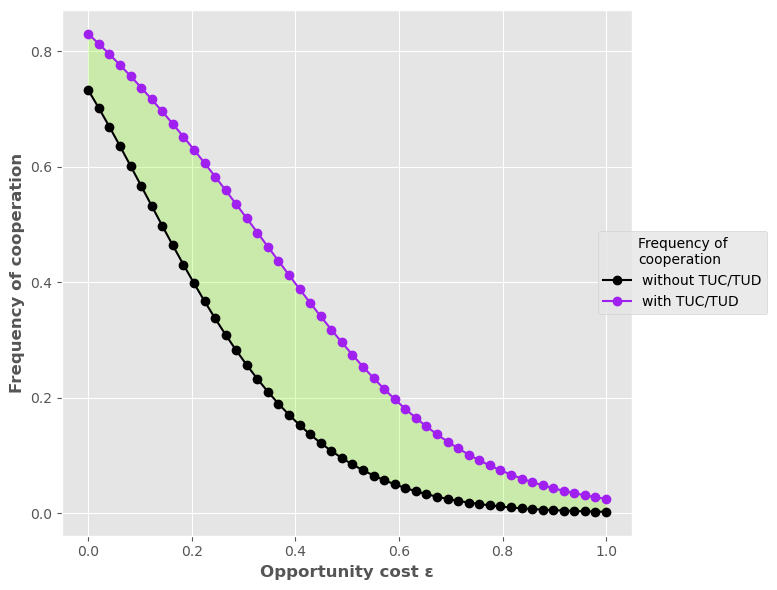

In [176]:
for eps in epsilon_values:
    
    # Without Trust Based Strategies
    payoff_matrix_without_trust = initialize_payoff_matrix(
        R=R, S=S, T=T, P=P, 
        theta=THETA, 
        check_co_player_probability=CHECK_PROBABILITY,
        epsilon=eps, 
        r=NUM_ROUNDS,
        with_trust_based_strategies=False
        
    )
    
    stationary_without_trust = get_stationary_distribution(payoff_matrix_without_trust)
    cooperation_without_trust.append(cooperation_frequency(stationary_without_trust, without_cooperation_strategies, THETA, NUM_ROUNDS))
    
    
    # With Trust Based Strategies
    payoff_matrix_with_trust = initialize_payoff_matrix(
        R=R, S=S, T=T, P=P, 
        theta=THETA, 
        check_co_player_probability=CHECK_PROBABILITY,
        epsilon=eps, 
        r=NUM_ROUNDS,
        with_trust_based_strategies=True
        
    )
    
    stationary_with_trust = get_stationary_distribution(payoff_matrix_with_trust)
    cooperation_with_trust.append(cooperation_frequency(stationary_with_trust, STRATEGIES, THETA, NUM_ROUNDS))
    
cooperation_without_trust = np.array(cooperation_without_trust)
cooperation_with_trust = np.array(cooperation_with_trust)

diff = cooperation_with_trust - cooperation_without_trust
        
        

plt.style.use("ggplot")
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(
    epsilon_values, cooperation_without_trust,
    color="black", marker="o",
    label="without TUC/TUD"
)

ax.plot(
    epsilon_values, cooperation_with_trust,
    color="#a020f0", marker="o",
    label="with TUC/TUD"
)

ax.fill_between(  #(source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.fill_between.html)
    epsilon_values,
    cooperation_without_trust,
    cooperation_with_trust,
    where=None,
    color="#7cfc00",
    alpha=0.25,
    interpolate=False
)

ax.set_xlabel("Opportunity cost ε", fontweight="bold")
ax.set_ylabel("Frequency of cooperation", fontweight="bold")


legend = ax.legend(title="""Frequency of\ncooperation""", 
                   loc='center right', 
                   bbox_to_anchor=(1.25, 0.5))
plt.tight_layout()
plt.show()




## Figure 4

/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.12/site-packages/egttools/utils.py:215: RuntimeWarning: Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in more than one eigenvalue of magnitute 1 (the Markov Chain is degenerate), so please be careful when analysing the results.
  warn(


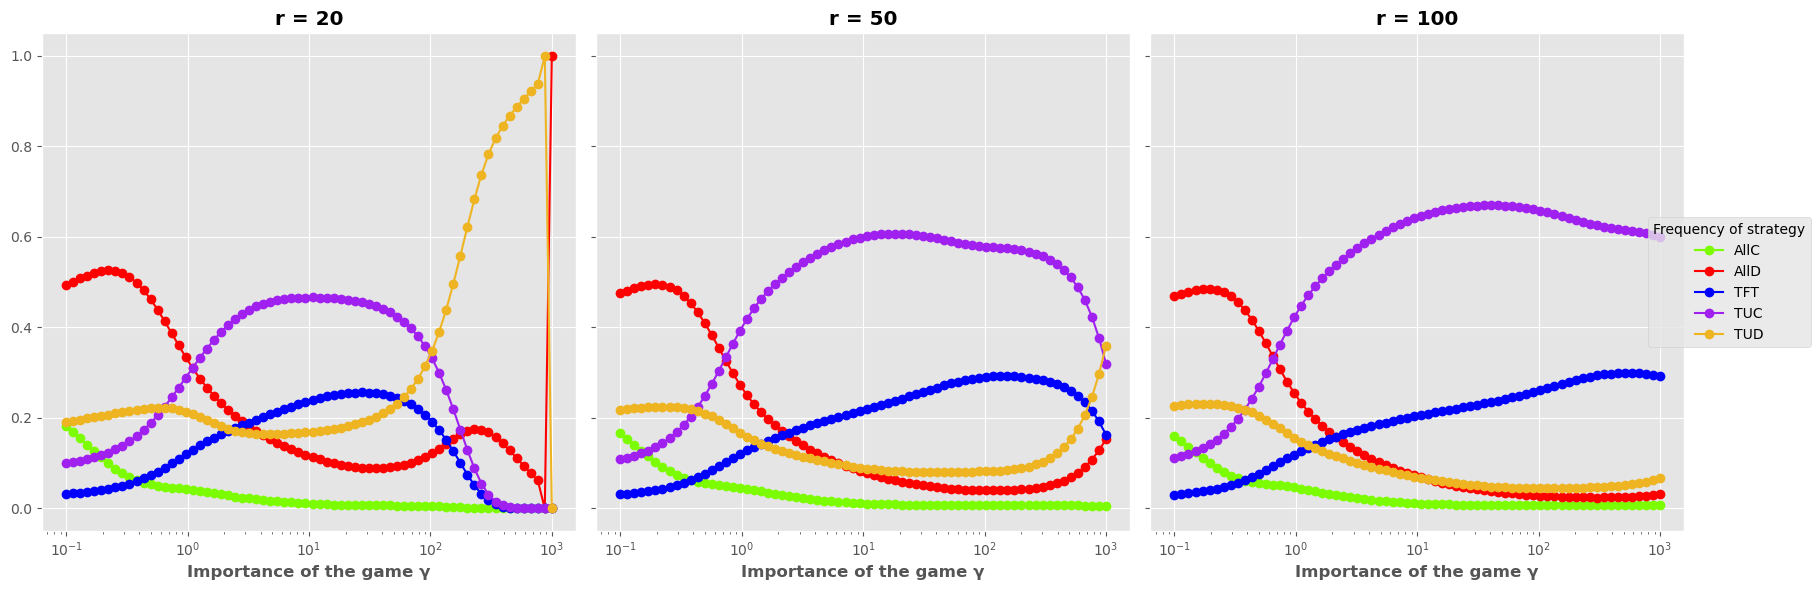

In [177]:
gamma_vals = np.logspace(-1, 3, 70) # Importance values 
r_vals = [20, 50, 100] # Number of rounds for short, medium and long interactions

plt.style.use("ggplot")

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, j in enumerate(r_vals):
    ax = axes[i]
    
    strategy_frequency_data = {strat: [] for strat in STRATEGIES}
    
    for g in gamma_vals:
        payoff_matrix = initialize_payoff_matrix(R=g*R, S=g*S, T=g*T, P=g*P, # Scaling payoffs
                                                 theta=THETA,
                                                 check_co_player_probability=CHECK_PROBABILITY,
                                                 epsilon=EPSILON,
                                                 r=j,
                                                 with_trust_based_strategies=True)
        
        
        frequencies = get_stationary_distribution(payoff_matrix)
        
        for m,n in enumerate(STRATEGIES):
            strategy_frequency_data[n].append(frequencies[m])
        
    
    for strategy in STRATEGIES:
        ax.semilogx(gamma_vals,
                    strategy_frequency_data[strategy],
                    label=strategy,
                    color=STRATEGY_COLORS[strategy],
                    marker="o")
    ax.set_title(f"r = {j}", fontweight="bold")
    ax.set_xlabel("Importance of the game γ", fontweight="bold")
    



legend = ax.legend(title="""Frequency of strategy""", 
                   loc='center right', 
                   bbox_to_anchor=(1.25, 0.5))

plt.tight_layout()
plt.show()


/opt/homebrew/Caskroom/miniconda/base/envs/machinelearning/lib/python3.12/site-packages/egttools/utils.py:215: RuntimeWarning: Some of the entries in the transition matrix are close to 1 (with a tolerance of 1e-11). This could result in more than one eigenvalue of magnitute 1 (the Markov Chain is degenerate), so please be careful when analysing the results.
  warn(


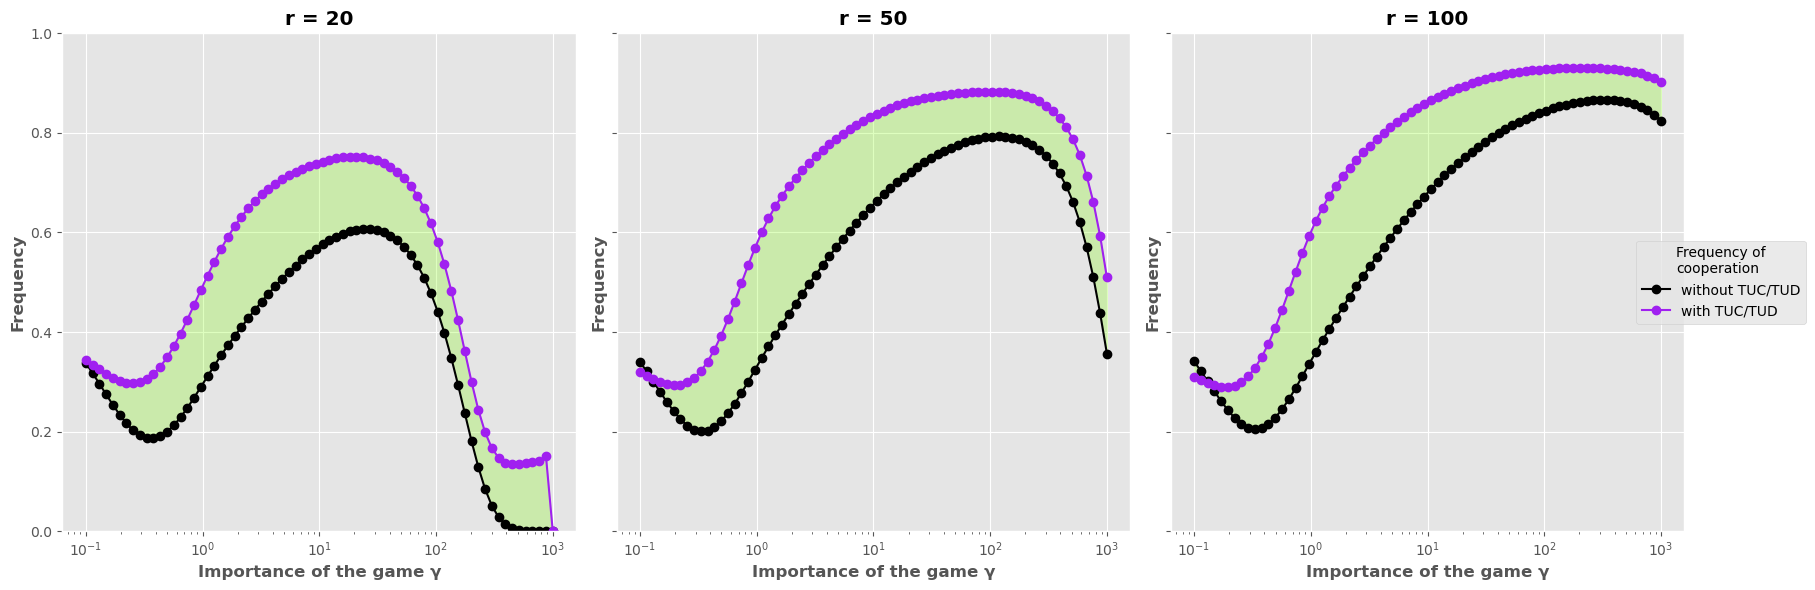

In [178]:
plt.style.use("ggplot")
 
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True) # source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html

for i, j in enumerate(r_vals):
    ax = axes[i]
    
    cooperation_without_trust = []
    cooperation_with_trust = []    
    
    for g in gamma_vals:
        
        # Computing payoff matrix for without trust
        payoff_matrix_without_trust = initialize_payoff_matrix(R=g*R, S=g*S, T=g*T, P=g*P, # Scaling payoffs
                                                 theta=THETA,
                                                 check_co_player_probability=CHECK_PROBABILITY,
                                                 epsilon=EPSILON,
                                                 r=j,
                                                 with_trust_based_strategies=False)
        
        # Calculating stationary distribution over non trust strategies
        frequencies_without_trust = get_stationary_distribution(payoff_matrix_without_trust)
        
        # Computing cooperation frequency
        cooperation_without_trust.append(cooperation_frequency(frequencies_without_trust,without_cooperation_strategies, THETA, j))
        
        
        # Computing payoff matrix for with trust
        payoff_matrix_with_trust = initialize_payoff_matrix(R=g*R, S=g*S, T=g*T, P=g*P, # Scaling payoffs
                                                 theta=THETA,
                                                 check_co_player_probability=CHECK_PROBABILITY,
                                                 epsilon=EPSILON,
                                                 r=j,
                                                 with_trust_based_strategies=True)
        
        
        frequencies_with_trust = get_stationary_distribution(payoff_matrix_with_trust)
        
        cooperation_with_trust.append(cooperation_frequency(frequencies_with_trust,STRATEGIES, THETA, j))
        
    cooperation_with_trust = np.array(cooperation_with_trust)
    cooperation_without_trust = np.array(cooperation_without_trust)

    diff = cooperation_with_trust - cooperation_without_trust



    ax.semilogx(
        gamma_vals, cooperation_without_trust,
        color="black", marker="o",
        label="without TUC/TUD"
    )

    ax.semilogx(
        gamma_vals, cooperation_with_trust,
        color="#a020f0", marker="o",
        label="with TUC/TUD"
    )

    ax.fill_between(  
        gamma_vals,
        cooperation_without_trust,
        cooperation_with_trust,
        where=None,
        color="#7cfc00",
        alpha=0.25,
        interpolate=False
    )

    ax.set_title(f"r = {j}", fontweight="bold")
    ax.set_xlabel("Importance of the game γ", fontweight="bold")
    ax.set_ylabel("Frequency", fontweight="bold")
    ax.set_ylim(0, 1.0)


legend = ax.legend(title="""Frequency of\ncooperation""", 
                    loc='center right', 
                    bbox_to_anchor=(1.25, 0.5))
plt.tight_layout()
plt.show()


## Figure 5

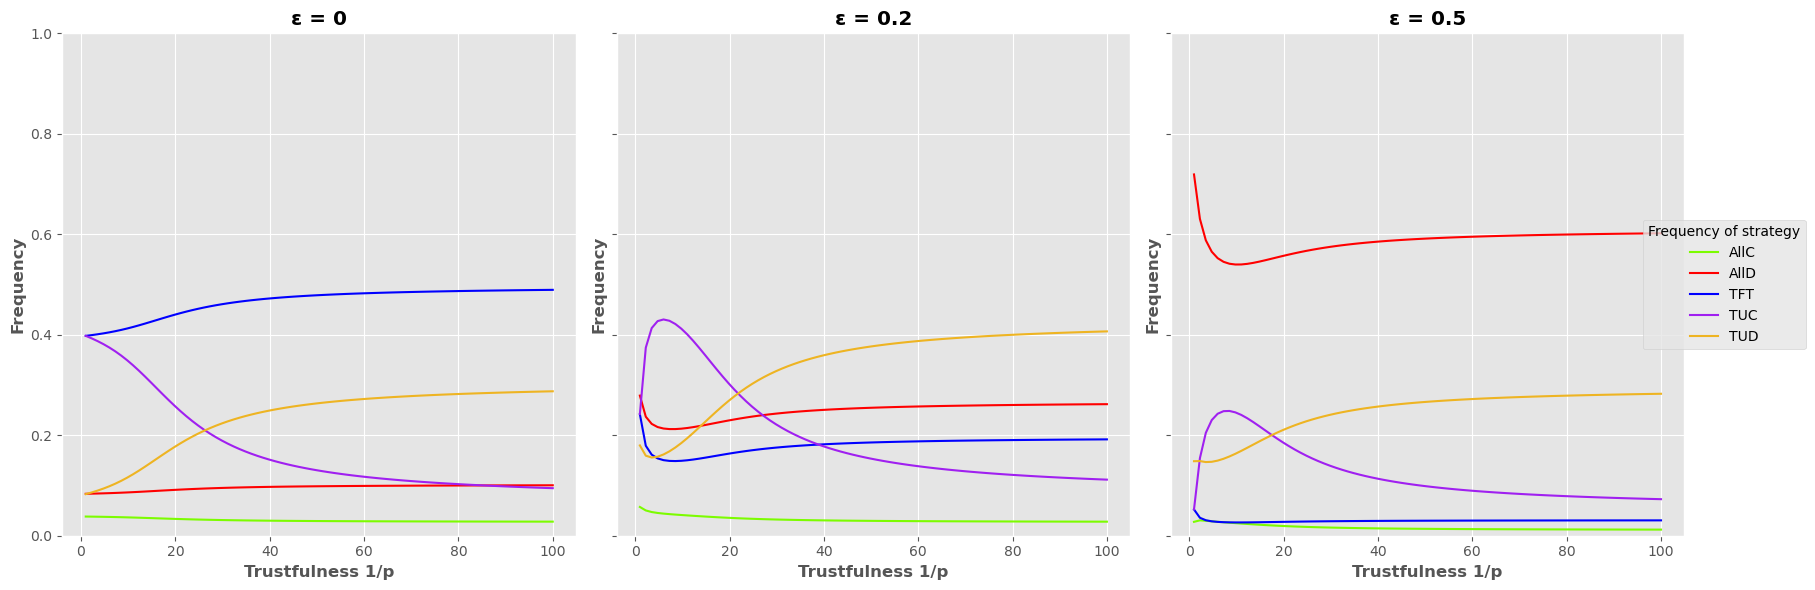

In [179]:
eps_vals = [0, 0.2, 0.5] # Opportunity Costs

trustfulness = np.linspace(1,100,80) # x-axis: 1/p

p_vals = 1.0/trustfulness # smaller p -> checking happens less often -> more trust

gamma = 1.0 # Importance γ 

plt.style.use("ggplot")

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, j in enumerate(eps_vals):
    ax = axes[i]
    
    strategy_frequency_data = {strat: [] for strat in STRATEGIES}
    
    for p in p_vals:
        payoff_matrix = initialize_payoff_matrix(R=gamma*R, S=gamma*S, T=gamma*T, P=gamma*P, # Scaling payoffs
                                                 theta=THETA,
                                                 check_co_player_probability=p,
                                                 epsilon=j,
                                                 r=NUM_ROUNDS,
                                                 with_trust_based_strategies=True)
        
        
        frequencies = get_stationary_distribution(payoff_matrix)
        
        for m,n in enumerate(STRATEGIES):
            strategy_frequency_data[n].append(frequencies[m])
        
    
    for strategy in STRATEGIES:
        ax.plot(trustfulness,
                strategy_frequency_data[strategy],
                label=strategy,
                color=STRATEGY_COLORS[strategy],
                )
    ax.set_title(f"ε = {j}", fontweight="bold")
    ax.set_xlabel("Trustfulness 1/p", fontweight="bold")
    ax.set_ylabel("Frequency", fontweight="bold")
    ax.set_ylim(0, 1.0)


legend = ax.legend(title="""Frequency of strategy""", 
                   loc='center right', 
                   bbox_to_anchor=(1.25, 0.5))

plt.tight_layout()
plt.show()


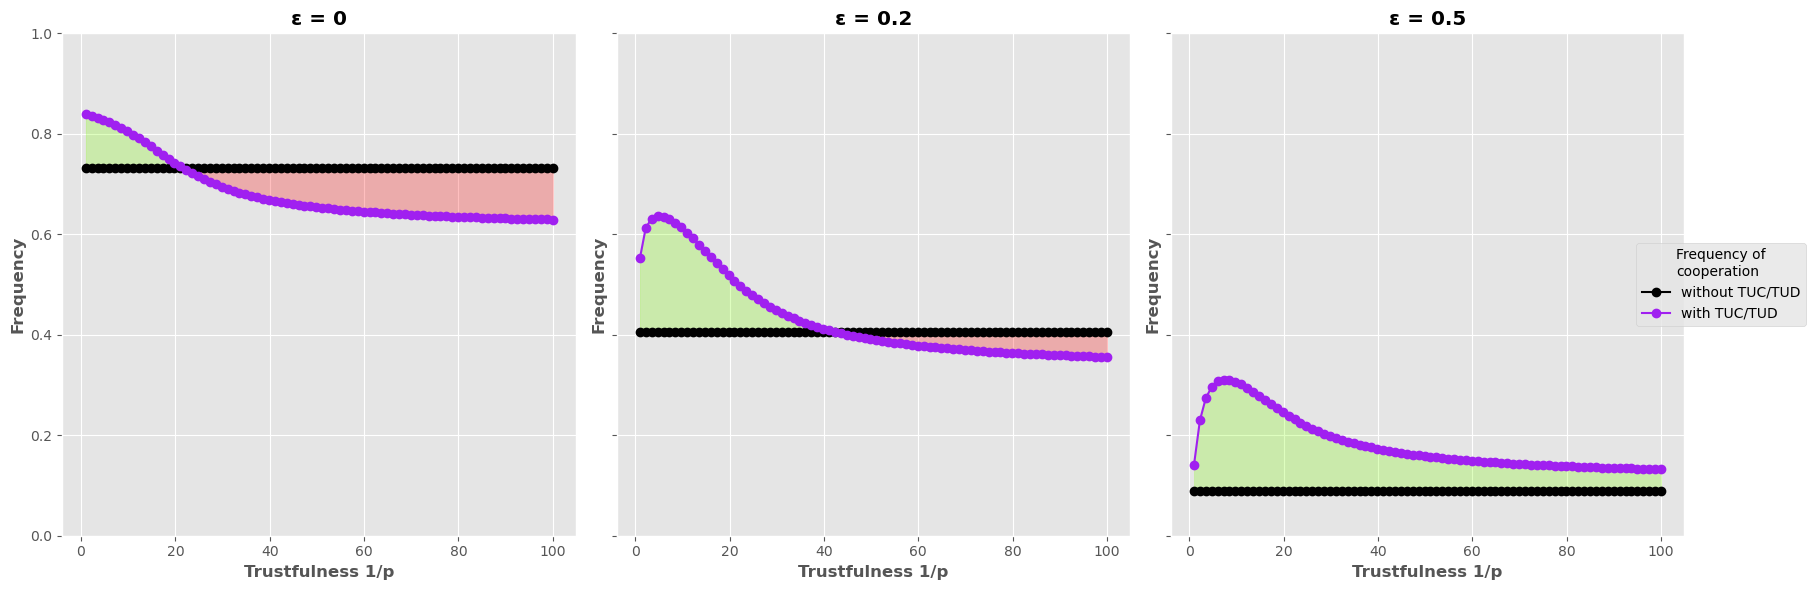

In [182]:
plt.style.use("ggplot")
 
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True) # source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html

for i, j in enumerate(eps_vals):
    ax = axes[i]
    
    cooperation_without_trust = []
    cooperation_with_trust = []    
    
    for p in p_vals:
        
        # Computing payoff matrix for without trust
        payoff_matrix_without_trust = initialize_payoff_matrix(R=gamma*R, S=gamma*S, T=gamma*T, P=gamma*P, # Scaling payoffs
                                                 theta=THETA,
                                                 check_co_player_probability=p,
                                                 epsilon=j,
                                                 r=NUM_ROUNDS,
                                                 with_trust_based_strategies=False)
        
        # Calculating stationary distribution over non trust strategies
        frequencies_without_trust = get_stationary_distribution(payoff_matrix_without_trust)
        
        # Computing cooperation frequency
        cooperation_without_trust.append(cooperation_frequency(frequencies_without_trust,without_cooperation_strategies, THETA, NUM_ROUNDS))
        
        
        # Computing payoff matrix for with trust
        payoff_matrix_with_trust = initialize_payoff_matrix(R=gamma*R, S=gamma*S, T=gamma*T, P=gamma*P, # Scaling payoffs
                                                 theta=THETA,
                                                 check_co_player_probability=p,
                                                 epsilon=j,
                                                 r=NUM_ROUNDS,
                                                 with_trust_based_strategies=True)
        
        
        frequencies_with_trust = get_stationary_distribution(payoff_matrix_with_trust)
        
        cooperation_with_trust.append(cooperation_frequency(frequencies_with_trust,STRATEGIES, THETA, NUM_ROUNDS))
        
    cooperation_with_trust = np.array(cooperation_with_trust)
    cooperation_without_trust = np.array(cooperation_without_trust)

    diff = cooperation_with_trust - cooperation_without_trust



    ax.plot(
        trustfulness, cooperation_without_trust,
        color="black", marker="o",
        label="without TUC/TUD"
    )

    ax.plot(
        trustfulness, cooperation_with_trust,
        color="#a020f0", marker="o",
        label="with TUC/TUD"
    )

    ax.fill_between(  
        trustfulness,
        cooperation_without_trust,
        cooperation_with_trust,
        where=(diff>=0),
        color="#7cfc00",
        alpha=0.25,
        interpolate=True
    )
    ax.fill_between(  
        trustfulness,
        cooperation_without_trust,
        cooperation_with_trust,
        where=(diff<0),
        color="red",
        alpha=0.25,
        interpolate=True
    )
    

    ax.set_title(f"ε = {j}", fontweight="bold")
    ax.set_xlabel("Trustfulness 1/p", fontweight="bold")
    ax.set_ylabel("Frequency", fontweight="bold")
    ax.set_ylim(0, 1.0)


legend = ax.legend(title="""Frequency of\ncooperation""", 
                    loc='center right', 
                    bbox_to_anchor=(1.25, 0.5))
plt.tight_layout()
plt.show()
